In [1]:
"""%load_ext autoreload
%autoreload 2
%load_ext wurlitzer
"""
import sys
import json
from ruamel.yaml import YAML
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import gc

import lossmaps as lm

from scipy.constants import c as clight

from cpymad.madx import Madx

import xpart as xp
import xtrack as xt
import xobjects as xo
#import xdyna as xd
import xcoll as xc
import xfields as xf
import xdeps as xd
# import xboinc as xb

import subprocess
import os


print('xcoll version: ', xc.__version__)
print('xtrack version: ', xt.__version__)
print('xpart version: ', xp.__version__)
print('xobjects version: ', xo.__version__)
print('xfields version: ', xf.__version__)
print('xdeps version: ', xd.__version__)

xcoll version:  0.4.0
xtrack version:  0.64.1
xpart version:  0.18.5
xobjects version:  0.4.3
xfields version:  0.20.1
xdeps version:  0.6.2


In [2]:
# context = xo.ContextCpu(omp_num_threads=26)
context = xo.ContextCpu()
context.allow_prebuilt_kernels = False
context.allow_prebuilt_kernels

False

### Crystal Setup

In [3]:
#branch_name = 'main'
branch_name = 'release_v0.4.0'
#branch_name = 'NoMoreManager'
#branch_name = 'KayStatus'
#branch_name = 'ForKayAsSixtrack'
#branch_name = 'ForKayBetterEtaWithTransition'
#branch_name = 'ForKayBetterEtaWithoutTransition'
#branch_name = 'sixtrack'

In [4]:
if branch_name in ['KayStatus', 'ForKayAsSixtrack', 'ForKayBetterEtaWithTransition', 'ForKayBetterEtaWithoutTransition']:
    coll = xc.EverestCrystal(length=0.002, material=xc.materials.SiliconCrystal, bending_angle=144e-6,
                            xdim=0.002, ydim=0.05, side='+', lattice='strip', jaw=0.001)
elif branch_name == 'main':
    coll = xc.EverestCrystal(length=0.002, material=xc.materials.SiliconCrystal, bending_angle=144e-6,
                            xdim=0.002, ydim=0.05, side='+', lattice='strip', jaw=0.001)
elif branch_name in ['NoMoreManager', 'release_v0.4.0']:
    coll = xc.EverestCrystal(length=0.002, material=xc.materials.SiliconCrystal, bending_angle=144e-6,
                            width=0.002, height=0.05, side='+', lattice='strip', jaw=0.001)
elif branch_name == 'sixtrack':
    class collimator():
        def __init__(self, bending_angle):
            self.bending_angle = bending_angle
    coll = collimator(bending_angle=144e-6)
    
xp_crit_comp = 9.130328408646464e-06

In [7]:
coll._critical_angle

9.130328408646464e-06

In [6]:
test = True
if test:
    num_part = 1
    x_init   = np.random.normal(loc=1.5e-3, scale=75.e-6, size=num_part)
    px_init  = np.random.uniform(low=-50*1.e-6, high=250*1.e-6, size=num_part)
    y_init   = np.random.normal(loc=0., scale=1e-6, size=num_part)
    py_init  = np.random.normal(loc=0., scale=1.e-8, size=num_part)
    part = xp.Particles(x=x_init, px=px_init, y=y_init, py=py_init, delta=0, p0c=4e11)
    coll.track(part)
    print('bending_angle: ', coll.bending_angle)
    print('bending_radius: ', coll.bending_radius)
    print('critical angle: ', coll.critical_angle, coll.critical_angle==xp_crit_comp)

bending_angle:  0.000144
bending_radius:  13.88888893688889
critical angle:  9.130328408646464e-06 True


In [5]:
#EOS_PATH  = Path('/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/xcoll_vers_test')
#EOS_PATH  = Path('/eos/home-k/kdewhurs/SWAN_projects/27_Test_Xcoll_Versions_for_chiara/KayStatus')
#EOS_PATH  = Path('/eos/home-k/kdewhurs/SWAN_projects/27_Test_Xcoll_Versions_for_chiara/ForKayAsSixtrack')
EOS_PATH  = Path('/eos/home-k/kdewhurs/SWAN_projects/27_Test_Xcoll_Versions_for_chiara/ForKayBetterEtaWithTransition')
#EOS_PATH  = Path('/eos/home-k/kdewhurs/SWAN_projects/27_Test_Xcoll_Versions_for_chiara/ForKayBetterEtaWithoutTransition')

### Tracking

In [ ]:
tot_part = 0

for i in range(300):
    
    print('\nIteration: ', i, ",    range: ", (-50+i), ' , ',(-51+i), 'urad')
    num_part = int(3.33334e6)
    x_init   = np.random.normal(loc=1.5e-3, scale=75.e-6, size=num_part)
    px_init  = np.random.uniform(low=(-50+i)*1.e-6, high=(-51+i)*1.e-6, size=num_part)
    y_init   = np.random.normal(loc=0., scale=1e-6, size=num_part)
    py_init  = np.random.normal(loc=0., scale=1.e-8, size=num_part)
    part = xp.Particles(x=x_init, px=px_init, y=y_init, py=py_init, delta=0, p0c=4e11)

    del x_init, px_init, y_init, py_init
    gc.collect()

    part_init_px = part.px.copy().astype('float32')


    %time coll.track(part)
    # Sort particles again
    part.sort(interleave_lost_particles=True)

    alive = (part.state > 0 )
    df = pd.DataFrame({'px_in': part_init_px[alive], 'px_diff': part.px[alive].astype('float32') - part_init_px[alive]})
    mask =  (df.px_diff < 200.e-6) & ( df.px_diff > -75.e-6)

    del part, part_init_px
    gc.collect()

    # if i ==0:
    df[mask].to_hdf(Path( EOS_PATH / 'slices', f'branch_{branch_name}_{-50+i}urad.h5'), key='px', format='table', mode='a',
                complevel=9, complib='blosc')
    # else:
    #     store = pd.HDFStore(Path(Path.cwd(), f'branch_{branch_name}_{-50+i}urad.h5'))
    #     store.append('px', df)
    #     store.close()
    
    tot_part += len(df)
    print('N part: ' ,len(df))
    
    del df
    gc.collect()


print('Total particles: ', tot_part)


In [8]:
coll.critical_angle

9.130328408646464e-06

In [9]:
print('Total particles:  ', tot_part)


Total particles:   996094120


In [ ]:
process_sixtrack = False

if process_sixtrack:
    file_list = os.listdir(Path(EOS_PATH /'sixtrack_files').absolute().as_posix())
    file_list = [f for f in file_list if 'ang' in f]

    branch_name = 'sixtrack'

    tot_part = 0

    for file in file_list:
        df = pd.read_csv(Path(EOS_PATH / 'sixtrack_files', file), sep='\t', header=None, names=['px_in', 'px_diff'],  on_bad_lines='warn')
        df = df.apply(pd.to_numeric, errors='coerce').dropna()
        df['px_in'] = df['px_in'].astype('float32')
        df['px_diff'] = df['px_diff'].astype('float32')
        mask =  (df.px_diff < 200.e-6) & ( df.px_diff > -75.e-6)
        n = file.split('_')[1]
        df[mask].to_hdf(Path( EOS_PATH / 'slices', f'branch_{branch_name}_{n}urad.h5'), key='px', format='table', mode='a',
                    complevel=9, complib='blosc')
        tot_part += len(df)
        print('N part: ' ,len(df))
        
        del df
        gc.collect()


    print('Total particles: ', tot_part) #849889113


### Loading


In [6]:
file_list = os.listdir(Path(EOS_PATH /'slices').absolute().as_posix())
file_list = [f for f in file_list if branch_name in f]
files = {}
for file in file_list:
    files[int(file.split('_')[-1].split('u')[0])-1] = file

In [9]:
if branch_name in ['sixtrack', 'ForKayBetterEtaWithoutTransition', 'ForKayBetterEtaWithTransition']:
    files = {k + 1: v for k, v in files.items()}


In [10]:
files

{-10: 'branch_ForKayBetterEtaWithTransition_-10urad.h5',
 -11: 'branch_ForKayBetterEtaWithTransition_-11urad.h5',
 -12: 'branch_ForKayBetterEtaWithTransition_-12urad.h5',
 -13: 'branch_ForKayBetterEtaWithTransition_-13urad.h5',
 -14: 'branch_ForKayBetterEtaWithTransition_-14urad.h5',
 -15: 'branch_ForKayBetterEtaWithTransition_-15urad.h5',
 -16: 'branch_ForKayBetterEtaWithTransition_-16urad.h5',
 -17: 'branch_ForKayBetterEtaWithTransition_-17urad.h5',
 -18: 'branch_ForKayBetterEtaWithTransition_-18urad.h5',
 -19: 'branch_ForKayBetterEtaWithTransition_-19urad.h5',
 -1: 'branch_ForKayBetterEtaWithTransition_-1urad.h5',
 -20: 'branch_ForKayBetterEtaWithTransition_-20urad.h5',
 -21: 'branch_ForKayBetterEtaWithTransition_-21urad.h5',
 -22: 'branch_ForKayBetterEtaWithTransition_-22urad.h5',
 -23: 'branch_ForKayBetterEtaWithTransition_-23urad.h5',
 -24: 'branch_ForKayBetterEtaWithTransition_-24urad.h5',
 -25: 'branch_ForKayBetterEtaWithTransition_-25urad.h5',
 -26: 'branch_ForKayBetterEtaWith

In [11]:
len(files)

300

In [12]:
def load(low_lim, high_lim = None, files=files, perc = 1):
    

    with pd.HDFStore(Path(EOS_PATH, 'slices', files[low_lim]), 'r') as store:
        total_rows = store.get_storer('px').nrows
    store.close()
    rows_to_read = int(total_rows * perc)
    try:
        df = pd.read_hdf(Path(EOS_PATH, 'slices', files[low_lim]), key='px', start=0, stop=rows_to_read)
    except Exception as e:
        print(f"Skipping first file due to error: {e}")
        

    if high_lim is not None:
        for i in range(low_lim+1, high_lim):
            with pd.HDFStore(Path(EOS_PATH, 'slices', files[i]), 'r') as store:
                total_rows = store.get_storer('px').nrows
            store.close()
            rows_to_read = int(total_rows * perc)
            try:
                df = pd.concat([df, pd.read_hdf(Path(EOS_PATH, 'slices', files[i]), key='px', start=0, stop=rows_to_read)])
            except Exception as e:
                print(f"Skipping file {i} due to error: {e}")
                continue
            #df = pd.concat([df, pd.read_hdf(Path(EOS_PATH, 'slices', files[i]), key='px', start=0, stop=rows_to_read)])

    if branch_name == 'release_v0.4.0':
        df = df.rename(columns={'part_init_px': 'px_in', 'part_Diff_px': 'px_diff'})

    if branch_name == 'sixtrack':
        df = df[(df.px_in > -50e-6) & (df.px_in < 206e-6)]
        if low_lim < 0:
            low_lim = low_lim -1

    """if high_lim is not None:
        df = df[(df.px_in > low_lim*1e-6) & (df.px_in < high_lim*1e-6)]
    else:
        df = df[(df.px_in > low_lim*1e-6) & (df.px_in < (low_lim+1)*1e-6)]"""
        

    return df

### Plotting

##### Finding critical angle

In [66]:
files

{-11: 'branch_ForKayBetterEtaWithoutTransition_-10urad.h5',
 -12: 'branch_ForKayBetterEtaWithoutTransition_-11urad.h5',
 -13: 'branch_ForKayBetterEtaWithoutTransition_-12urad.h5',
 -14: 'branch_ForKayBetterEtaWithoutTransition_-13urad.h5',
 -15: 'branch_ForKayBetterEtaWithoutTransition_-14urad.h5',
 -16: 'branch_ForKayBetterEtaWithoutTransition_-15urad.h5',
 -17: 'branch_ForKayBetterEtaWithoutTransition_-16urad.h5',
 -18: 'branch_ForKayBetterEtaWithoutTransition_-17urad.h5',
 -19: 'branch_ForKayBetterEtaWithoutTransition_-18urad.h5',
 -20: 'branch_ForKayBetterEtaWithoutTransition_-19urad.h5',
 -2: 'branch_ForKayBetterEtaWithoutTransition_-1urad.h5',
 -21: 'branch_ForKayBetterEtaWithoutTransition_-20urad.h5',
 -22: 'branch_ForKayBetterEtaWithoutTransition_-21urad.h5',
 -23: 'branch_ForKayBetterEtaWithoutTransition_-22urad.h5',
 -24: 'branch_ForKayBetterEtaWithoutTransition_-23urad.h5',
 -25: 'branch_ForKayBetterEtaWithoutTransition_-24urad.h5',
 -26: 'branch_ForKayBetterEtaWithoutTransi

In [16]:
df = load(-11, 11)

Text(0.5, 1.0, 'Branch: ForKayBetterEtaWithTransition')

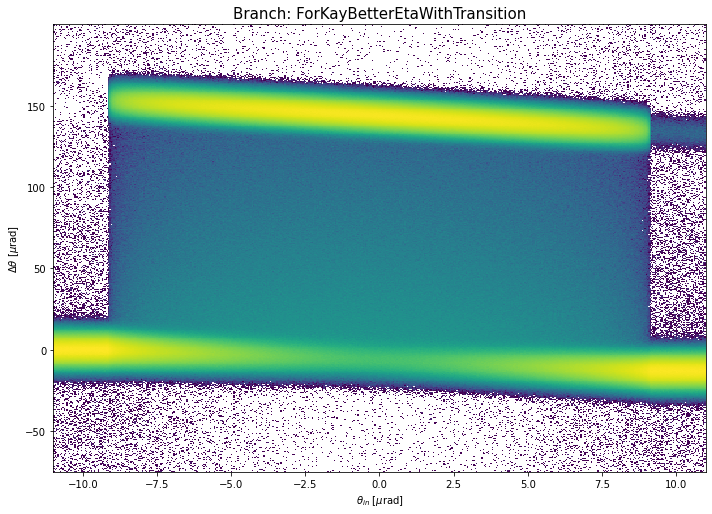

In [17]:
plt.figure(figsize=(10,7))

_ = plt.hist2d(df.px_in*1.e6, df.px_diff*1.e6, 500, norm=mpl.colors.LogNorm())
#plt.xlim(-30, 180)
#plt.ylim(-55, 205)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.tight_layout()
plt.title(f'Branch: {branch_name}', fontsize=15)
#plt.savefig(f"Distribution_{branch_name}.png", dpi=300)

In [18]:
mask_zoom =  (df.px_diff > 120.e-6) & (df.px_in > -10e-6) & (df.px_in < -7e-6) 

bigger_limit = 100
fine_limit = 20

print("Scan.. ")
lower = -8.5
upper = -10.5
steps = np.linspace(lower, upper, -int((upper-lower)/0.1)+1)
lens = []
idx = 0
for i in steps:
    m = mask_zoom & (df.px_in > i*1.e-6) & (df.px_in < (i+0.1)*1.e-6)
    lens.append(len(df.px_in[m]))
    print('range: [', i, ', ', i+0.1, ']', lens[idx], lens[idx]-lens[idx-1] if idx > 0 else lens[idx])
    if lens[idx] <bigger_limit and lens[idx-1] > bigger_limit:
        lim_idx = idx-1
    idx += 1

print('\nFine in [', steps[lim_idx+1],', ', steps[lim_idx-1], ']')
lens_fine = []
idx = 0
fine_steps =  np.linspace(steps[lim_idx-1],steps[lim_idx+1], 21)
for i in fine_steps:
    print(i, i+0.01)
    m = mask_zoom & (df.px_in > i*1.e-6) & (df.px_in < (i+0.01)*1.e-6)
    lens_fine.append(len(df.px_in[m]))
    print('range: [', i, ', ', i+0.01, ']', lens_fine[idx], lens_fine[idx]-lens_fine[idx-1] if idx > 0 else lens[idx])
    if lens_fine[idx] <fine_limit and lens_fine[idx-1] > fine_limit:
        lim_idx_fine = idx-1
    idx += 1

print(fine_steps[lim_idx_fine-1], fine_steps[lim_idx_fine])

xp_crit = abs(np.mean(fine_steps[lim_idx_fine-1:lim_idx_fine+1]))*1e-6
print('\n\nxp_crit: ', xp_crit, '\t xp_crit_comp: ', xp_crit_comp, '\t diff: ', xp_crit - xp_crit_comp)




Scan.. 
range: [ -8.5 ,  -8.4 ] 106930 106930
range: [ -8.6 ,  -8.5 ] 98641 -8289
range: [ -8.7 ,  -8.6 ] 90371 -8270
range: [ -8.8 ,  -8.700000000000001 ] 79998 -10373
range: [ -8.9 ,  -8.8 ] 69342 -10656
range: [ -9.0 ,  -8.9 ] 55596 -13746
range: [ -9.1 ,  -9.0 ] 36479 -19117
range: [ -9.2 ,  -9.1 ] 4694 -31785
range: [ -9.3 ,  -9.200000000000001 ] 61 -4633
range: [ -9.4 ,  -9.3 ] 69 8
range: [ -9.5 ,  -9.4 ] 56 -13
range: [ -9.6 ,  -9.5 ] 54 -2
range: [ -9.7 ,  -9.6 ] 43 -11
range: [ -9.8 ,  -9.700000000000001 ] 50 7
range: [ -9.9 ,  -9.8 ] 67 17
range: [ -10.0 ,  -9.9 ] 49 -18
range: [ -10.1 ,  -10.0 ] 0 -49
range: [ -10.2 ,  -10.1 ] 0 0
range: [ -10.3 ,  -10.200000000000001 ] 0 0
range: [ -10.4 ,  -10.3 ] 0 0
range: [ -10.5 ,  -10.4 ] 0 0

Fine in [ -9.3 ,  -9.1 ]
-9.1 -9.09
range: [ -9.1 ,  -9.09 ] 2427 106930
-9.11 -9.1
range: [ -9.11 ,  -9.1 ] 2116 -311
-9.12 -9.11
range: [ -9.12 ,  -9.11 ] 1606 -510
-9.129999999999999 -9.12
range: [ -9.129999999999999 ,  -9.12 ] 930 -676
-9.1

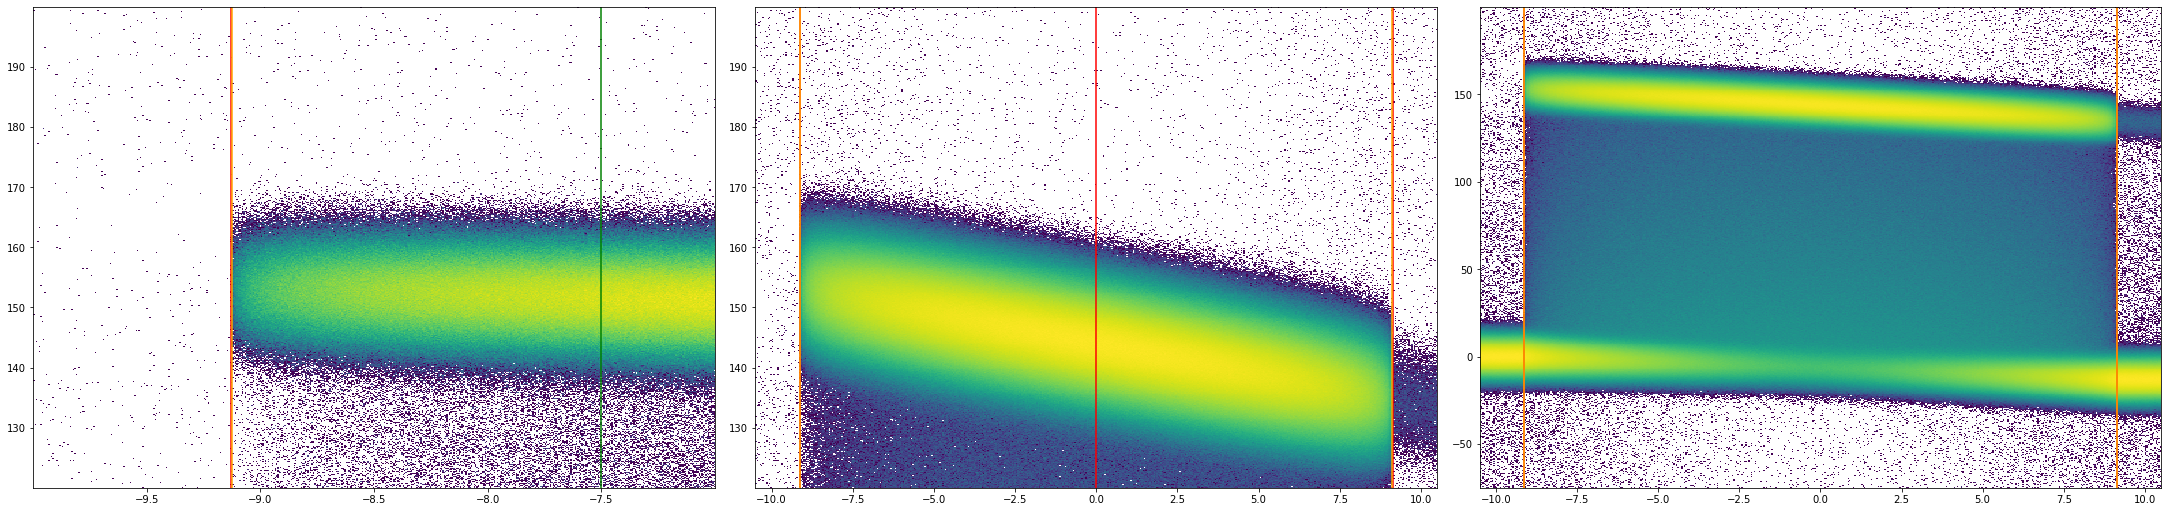

In [19]:
fig, ax= plt.subplots(1,3,layout='constrained',  figsize=(30,7))

_ = ax[0].hist2d(df.px_in[mask_zoom]*1.e6, df.px_diff[mask_zoom]*1.e6, 500, norm=mpl.colors.LogNorm())

#plt.axvline(0, color='red')
#plt.axvline(xp_crit_comp*1.e6, color='red')
ax[0].axvline(-xp_crit_comp*1.e6, color='red')
ax[0].axvline(-10.5, color='g')
ax[0].axvline(-7.5, color='g')
ax[0].axvline(-xp_crit*1.e6, color='orange')


mask_zoom2 = (df.px_diff > 120.e-6) &  (df.px_in > -10.5e-6) & (df.px_in < 10.5e-6) 

_ = ax[1].hist2d(df.px_in[mask_zoom2]*1.e6,  df.px_diff[mask_zoom2]*1.e6, 500, norm=mpl.colors.LogNorm())

ax[1].axvline(0, color='red')
ax[1].axvline(xp_crit_comp*1.e6, color='red')
ax[1].axvline(-xp_crit_comp*1.e6, color='red')
ax[1].axvline(-xp_crit*1.e6, color='orange')
ax[1].axvline(xp_crit*1.e6, color='orange')

mask_zoom3 =   (df.px_in > -10.5e-6) & (df.px_in < 10.5e-6) 
_ = ax[2].hist2d(df.px_in[mask_zoom3]*1.e6, df.px_diff[mask_zoom3]*1.e6, 500, norm=mpl.colors.LogNorm())
ax[2].axvline(xp_crit_comp*1.e6, color='red')
ax[2].axvline(-xp_crit_comp*1.e6, color='red')
ax[2].axvline(-xp_crit*1.e6, color='orange')
ax[2].axvline(xp_crit*1.e6, color='orange')




##### Channeling Efficiency

In [20]:
from scipy.optimize import curve_fit

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def fit(data):

    hist, bins = np.histogram(data, bins=100)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    initial_guess = [np.max(hist), np.mean(data), np.std(data)]
    popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)
    return popt

def fit_gaussian(data, ax, xlims = None, return_fit = False):
  
    fit_data = fit(data)
    
    if xlims is None:
        xmin, xmax = ax.get_xlim()
    else:
        xmin, xmax = xlims[0], xlims[1]

    hist_values = np.array([rect.get_height() for rect in ax.patches])
    bin_edges = np.array([rect.get_x() for rect in ax.patches])

    hist_values = hist_values[np.where(bin_edges >= min(data))[0][0]:]
    bin_edges = [i for i in bin_edges if i >= min(data)]

    x = np.linspace(xmin, xmax, len(hist_values))

    # Calculate the area of the histogram
    bin_widths = np.diff(bin_edges)  
    bin_widths = np.append(bin_widths, 0) 
    hist_area = np.sum(hist_values * bin_widths) 

    tmp_y = gaussian(x, fit_data[0], fit_data[1], fit_data[2])
    funct_area = np.trapz(tmp_y, x=x)

    ax.plot(x, gaussian(x, fit_data[0]/funct_area*hist_area, fit_data[1], fit_data[2]), 'g', linestyle = '-', linewidth=2)
    print('mean: ', fit_data[1], 'std: ', fit_data[2])

    if return_fit:
        return fit_data

In [21]:
checks = False

if checks:

    mask_ch = (df.px_in < xp_crit) & (df.px_in > -xp_crit) 

    plt.figure()
    _ = plt.hist2d(df.px_in[mask_ch]*1.e6,df.px_diff[mask_ch]*1.e6, 500, norm=mpl.colors.LogNorm())
    plt.xlim(-15, 15)
    plt.ylim(-55, 205)
    plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
    plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
    plt.tight_layout()

    plt.figure()
    _ = plt.hist(df.px_diff[mask_ch]*1.e6, bins=500,)

    fig, ax = plt.subplots()
    fit_lim = 120e-6
    fit_mask = (df.px_diff > fit_lim) & mask_ch
    ax.hist(df.px_diff[fit_mask], 393)
    fit_gaussian(df.px_diff[fit_mask], ax)



mean:  0.0001439852166093198 std:  6.743397584993582e-06
Chann efficiency:  0.6639129468737623


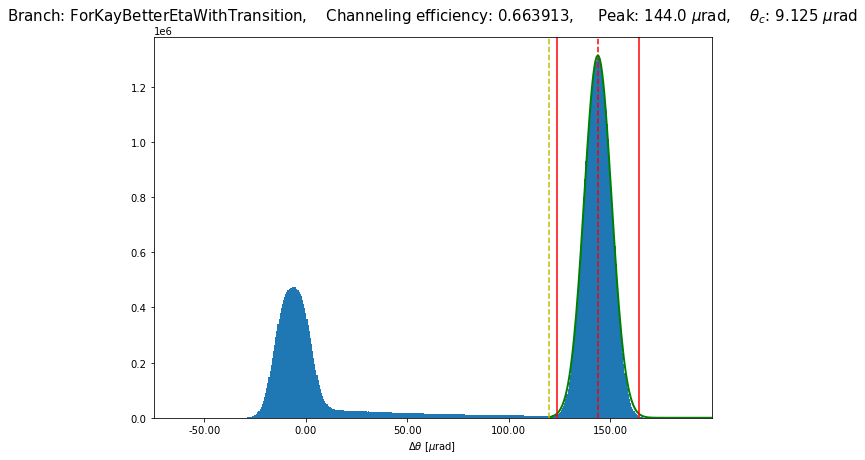

In [22]:
fig, ax = plt.subplots(figsize=(10,7))

mask_ch = (df.px_in < xp_crit) & (df.px_in > -xp_crit) 
#x = df.px_in[mask_ch]*1.e6
ang_defl = df.px_diff[mask_ch]
del mask_ch
gc.collect()

_ = ax.hist(ang_defl, 500)
ax.axvline(coll.bending_angle, color='r', linestyle='--')
fit_lim = 120e-6
fit_param = fit_gaussian(ang_defl[ang_defl > fit_lim], ax, xlims = (fit_lim, max(ang_defl)), return_fit=True)

sig = fit_param[2]
peak = fit_param[1]
ax.axvline(fit_lim, color='y', linestyle='--')
ax.axvline((coll.bending_angle+3*sig), color='r')
ax.axvline((coll.bending_angle-3*sig), color='r')


ax.set_xticks(ticks=ax.get_xticks(), labels=[f"{x_tick*1e6:.{2}f}" for x_tick in ax.get_xticks()])
ch = len(ang_defl[(ang_defl>coll.bending_angle-3*sig)&(ang_defl<coll.bending_angle+3*sig)])
print("Chann efficiency: ", ch/len(ang_defl))
ax.set_title(f'Branch: {branch_name},    Channeling efficiency: {ch/len(ang_defl):.6f},     Peak: {peak*1e6:.4}'+r' $\mu$rad'+r',    $\theta_c$:'+f' {xp_crit*1e6:.4}'+r' $\mu$rad',  fontsize=15)
ax.set_xlim(min(ang_defl), max(ang_defl))
# ax.set_xlim(min(data[m]), max(data[m]))
ax.set_xlabel(r'$\Delta\theta$ [$\mu$rad]')
#fig.tight_layout()
fig.savefig(f"Channeling_efficiency_{branch_name}.png", dpi=300)

In [23]:
len(df)

73103835

chann efficiency 
- MAIN: 0.6547 (22 min)
- NOMOREMANAGER: 


- For kay as Sixtrack 69775654

##### 2D plots

In [14]:
df = load(min(files.keys()), max(files.keys()), perc=0.19) 

Skipping file 52 due to error: HDF5 error back trace

  File "H5Dio.c", line 179, in H5Dread
    can't read data
  File "H5VLcallback.c", line 2011, in H5VL_dataset_read
    dataset read failed
  File "H5VLcallback.c", line 1978, in H5VL__dataset_read
    dataset read failed
  File "H5VLnative_dataset.c", line 166, in H5VL__native_dataset_read
    can't read data
  File "H5Dio.c", line 545, in H5D__read
    can't read data
  File "H5Dchunk.c", line 2569, in H5D__chunk_read
    unable to read raw data chunk
  File "H5Dchunk.c", line 3939, in H5D__chunk_lock
    data pipeline read failed
  File "H5Z.c", line 1390, in H5Z_pipeline
    filter returned failure during read
  File "hdf5-blosc/src/blosc_filter.c", line 254, in blosc_filter
    Blosc decompression error

End of HDF5 error back trace

Problems reading records.
Skipping file 59 due to error: HDF5 error back trace

  File "H5Dio.c", line 179, in H5Dread
    can't read data
  File "H5VLcallback.c", line 2011, in H5VL_dataset_read
 

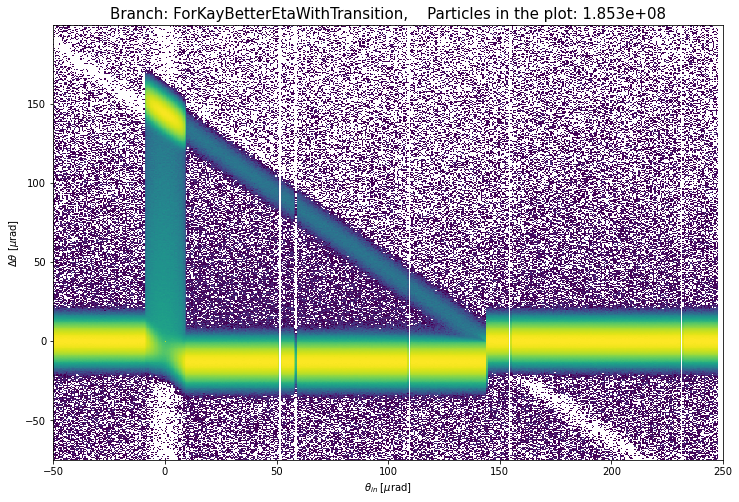

In [15]:
plt.figure(figsize=(12,8))

bins = 500
if branch_name == 'sixtrack':
    bins = round(500*256/300)

_ = plt.hist2d(df.px_in*1.e6, df.px_diff*1.e6, bins, norm=mpl.colors.LogNorm())
#plt.xlim(-30, 180)
#plt.ylim(-55, 205)
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.xlim(-50, 250)
#plt.tight_layout()
plt.title(f'Branch: {branch_name},    Particles in the plot: {len(df.px_in):.3e}', fontsize=15)
plt.savefig(f"Distribution_{branch_name}.png", dpi=300)

In [80]:
bins

427

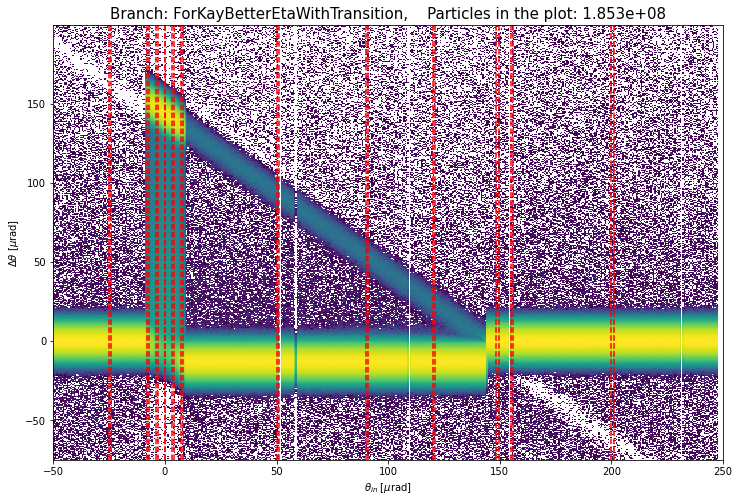

In [16]:
plt.figure(figsize=(12,8))

slices = [[-0.001, 0.001, 'CH_0'], [50, 51, 'VR'], [155, 156, 'TR VR-AM_2'], [3, 4, 'CH'], [-4, -3, 'CH'], [7,8, 'CH'], [-8, -7, 'CH'], [-25, -24, 'AM_1'], 
            [90, 91, 'VR'], [200, 201, 'AM_2'], [148.5, 149.5, 'TR'], [120,121, 'VR']]

slices = sorted(slices)
_ = plt.hist2d(df.px_in*1.e6, df.px_diff*1.e6,bins, norm=mpl.colors.LogNorm())
for sl in slices:
    plt.axvline(sl[0], color = 'r', linestyle='--')
    plt.axvline(sl[1], color = 'r', linestyle='--')
plt.ylabel(r'$\Delta\theta$ [$\mu$rad]')
plt.xlabel(r'$\theta_{in}$ [$\mu$rad]')
plt.xlim(-50, 250)
plt.title(f'Branch: {branch_name},    Particles in the plot: {len(df.px_in):.3e}', fontsize=15)
#plt.tight_layout()
plt.savefig(f"Slices_2d_{branch_name}.png", dpi=300)

#### Slices Plot

In [36]:
del df
gc.collect()

5844

<Figure size 720x504 with 0 Axes>

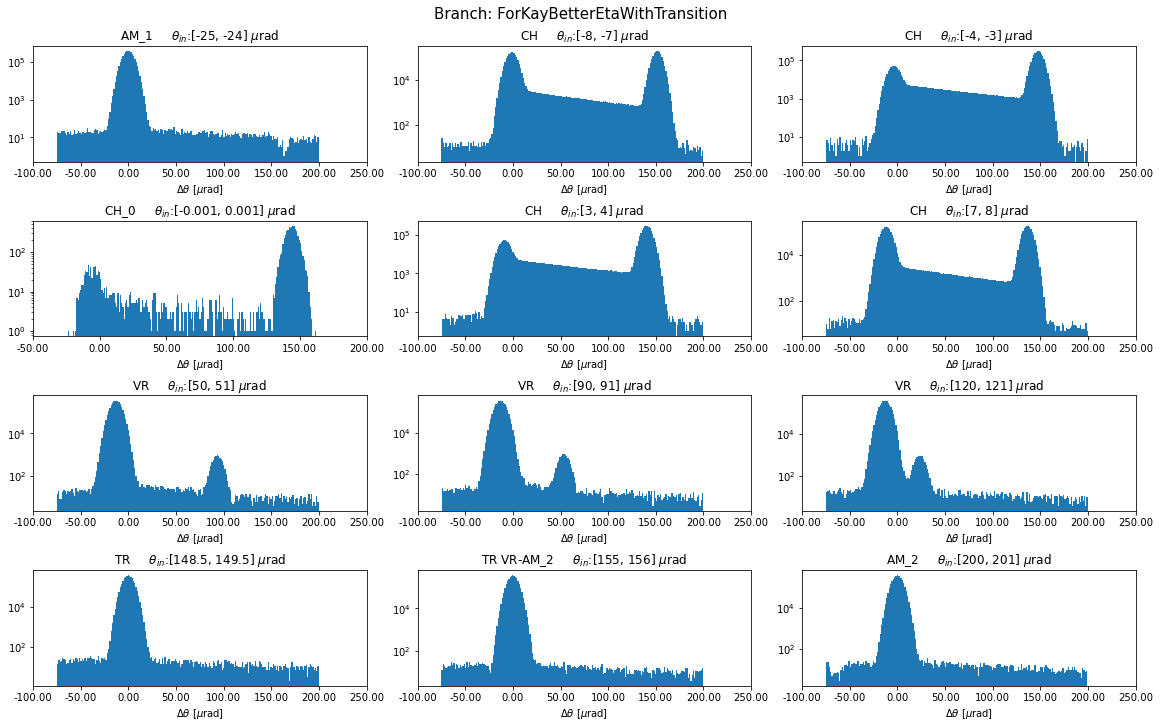

In [24]:

plt.figure(figsize=(10,7))

slices = [[-0.001, 0.001, 'CH_0'], [50, 51, 'VR'], [155, 156, 'TR VR-AM_2'], [3, 4, 'CH'], [-4, -3, 'CH'], [7,8, 'CH'], [-8, -7, 'CH'], [-25, -24, 'AM_1'], 
            [90, 91, 'VR'], [200, 201, 'AM_2'], [148.5, 149.5, 'TR'], [120,121, 'VR']]

slices = sorted(slices)
fig, ax= plt.subplots(4,3,layout='constrained',  figsize=(16,10))

for idx, a in enumerate(slices):  
    this_ax = ax[idx//3, idx%3]
    if slices[idx][0] in files.keys():
        df = load(slices[idx][0])
        this_ax.hist(df.px_diff, 200)
    else:
        df = load(int(np.floor(slices[idx][0])), int(np.ceil(slices[idx][1])))
        mask = (df.px_in > slices[idx][0]*1e-6) & (df.px_in < slices[idx][1]*1e-6)
        this_ax.hist(df.px_diff[mask], 200)
    this_ax.set_xticks(ticks=this_ax.get_xticks(), labels=[f"{x_tick*1e6:.{2}f}" for x_tick in this_ax.get_xticks()])
    this_ax.set_yscale('log')
    this_ax.set_title(f'{slices[idx][2]}'+ r'     $\theta_{in}$:' +f'[{slices[idx][0]}, {slices[idx][1]}' + r'] $\mu$rad')
    this_ax.set_xlabel(r'$\Delta\theta$ [$\mu$rad]')

fig.suptitle(f'Branch: {branch_name}',  fontsize=15)
fig.savefig(f"Slices_1d_{branch_name}.png", dpi=300)
    

In [19]:
def load(low_lim, high_lim = None, files=files, perc = 1):
    

    with pd.HDFStore(Path(EOS_PATH, 'slices', files[low_lim]), 'r') as store:
        total_rows = store.get_storer('px').nrows
    store.close()
    rows_to_read = int(total_rows * perc)
    try:
        df = pd.read_hdf(Path(EOS_PATH, 'slices', files[low_lim]), key='px', start=0, stop=rows_to_read)
    except Exception as e:
        print(f"Skipping first file due to error: {e}")
        

    if high_lim is not None:
        for i in range(low_lim+1, high_lim):
            with pd.HDFStore(Path(EOS_PATH, 'slices', files[i]), 'r') as store:
                total_rows = store.get_storer('px').nrows
            store.close()
            rows_to_read = int(total_rows * perc)
            try:
                df = pd.concat([df, pd.read_hdf(Path(EOS_PATH, 'slices', files[i]), key='px', start=0, stop=rows_to_read)])
            except Exception as e:
                print(f"Skipping file {i} due to error: {e}")
                continue
            #df = pd.concat([df, pd.read_hdf(Path(EOS_PATH, 'slices', files[i]), key='px', start=0, stop=rows_to_read)])

    if branch_name == 'release_v0.4.0':
        df = df.rename(columns={'part_init_px': 'px_in', 'part_Diff_px': 'px_diff'})

    if branch_name == 'sixtrack':
        df = df[(df.px_in > -50e-6) & (df.px_in < 206e-6)]
        if low_lim < 0:
            low_lim = low_lim -1

    """if high_lim is not None:
        df = df[(df.px_in > low_lim*1e-6) & (df.px_in < high_lim*1e-6)]
    else:
        df = df[(df.px_in > low_lim*1e-6) & (df.px_in < (low_lim+1)*1e-6)]"""
        

    return df

In [20]:
df = load(150, perc=0.19)

In [21]:
df

,px_in,px_diff
0,0.000149,-4.444621e-06
1,0.000150,4.143512e-07
2,0.000150,-3.464258e-06
3,0.000149,3.285051e-06
4,0.000149,4.258487e-06
...,...,...
630566,0.000149,-6.742674e-06
630567,0.000149,-1.618479e-06
630568,0.000149,-6.536284e-06
630569,0.000149,-4.531030e-06
